# Chapter 11: Material Balance Equation (Havlena-Odeh Method)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will build a Python Class to solve the General Material Balance Equation (MBE). We will use the **Havlena-Odeh linearization technique** to determine the Initial Oil in Place ($N$) from production history data.

**The General Equation:**
$$\text{Production} = \text{Expansion} + \text{Influx}$$
$$F = N [E_o + m E_g + E_{f,w}] + (W_e + W_{inj} B_w)$$

Where:
* **$F$ (Withdrawal):** Total underground fluid withdrawal.
* **$E_o$ (Oil Expansion):** Expansion of oil and its originally dissolved gas.
* **$E_g$ (Gas Expansion):** Expansion of the free gas cap.
* **$E_{f,w}$ (Rock/Water Expansion):** Expansion of connate water and pore volume reduction.
* **$N$:** Initial Oil in Place (STB).
* **$m$:** Ratio of initial gas cap volume to oil volume.

**The Strategy:**
If we assume no water influx ($W_e = 0$) and plot **$F$ (y-axis)** versus **Total Expansion $E_t$ (x-axis)**, the data points should form a **straight line**.
* The **Slope** of that line is **$N$**.
* If the line curves up, it suggests Water Influx is present.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

class MaterialBalanceSolver:
    def __init__(self, df_production, df_pvt, Pi, m=0, Boi=None, Bgi=None):
        """
        Initializes the MBE Solver.
        
        Args:
            df_production (DataFrame): Columns [Pressure, Np, Rp, Wp]
            df_pvt (DataFrame): Columns [Pressure, Bo, Rs, Bg]
            Pi (float): Initial Reservoir Pressure
            m (float): Ratio of initial gas cap to oil zone volume (m=0 for black oil)
            Boi, Bgi (float): Initial FVF values. If None, inferred from PVT table at Pi.
        """
        self.prod = df_production.sort_values('Pressure', ascending=False).reset_index(drop=True)
        self.pvt = df_pvt.sort_values('Pressure', ascending=False).reset_index(drop=True)
        self.Pi = Pi
        self.m = m
        
        # Interpolate PVT properties for exactly the pressures in production history
        # (This ensures we have matching Bo, Rs, Bg for every Np data point)
        self._interpolate_pvt_to_production_pressures()
        
        # Set Initial Conditions
        if Boi is None:
            self.Boi = np.interp(Pi, self.pvt['Pressure'][::-1], self.pvt['Bo'][::-1])
        else:
            self.Boi = Boi
            
        if Bgi is None:
            self.Bgi = np.interp(Pi, self.pvt['Pressure'][::-1], self.pvt['Bg'][::-1])
        else:
            self.Bgi = Bgi
            
        # Standard assumption for Rsi (Solution Gas at Pi)
        self.Rsi = np.interp(Pi, self.pvt['Pressure'][::-1], self.pvt['Rs'][::-1])

    def _interpolate_pvt_to_production_pressures(self):
        """Helper to map PVT table values to the specific production pressures"""
        pressures = self.prod['Pressure'].values
        
        # Note: np.interp requires x-coordinates to be increasing, so we flip [::-1]
        p_ref = self.pvt['Pressure'].values[::-1]
        
        self.prod['Bo'] = np.interp(pressures, p_ref, self.pvt['Bo'].values[::-1])
        self.prod['Rs'] = np.interp(pressures, p_ref, self.pvt['Rs'].values[::-1])
        self.prod['Bg'] = np.interp(pressures, p_ref, self.pvt['Bg'].values[::-1])
        
    def calculate_terms(self, cf=0, cw=0, Sw=0):
        """
        Calculates F, Eo, Eg, Efw terms for every time step.
        """
        df = self.prod.copy()
        
        # 1. Calculate Total Underground Withdrawal (F)
        # F = Np[Bt + (Rp - Rsi)Bg] + WpBw ... Simplified form:
        # F = Np(Bo + (Rp - Rs)Bg) + Wp*Bw (Assuming Wp=0 and Bw=1 for this exercise)
        # Accurate Definition: F = Np [ Bo + (Rp - Rs)Bg ]
        
        # Two-Phase FVF (Bt) definition: Bt = Bo + (Rsi - Rs)Bg
        # Tarek Ahmed Eq: F = Np [ Bt + (Rp - Rsi)Bg ]
        
        Bt = df['Bo'] + (self.Rsi - df['Rs']) * df['Bg']
        
        # The Withdrawal Term F
        # Np is in STB, Rp is in scf/STB
        df['F'] = df['Np'] * (Bt + (df['Rp'] - self.Rsi) * df['Bg'])
        
        # 2. Calculate Oil Expansion (Eo)
        # Eo = (Bt - Bti)
        # Bti = Boi (since at Pi, Rs=Rsi)
        Bti = self.Boi # + (self.Rsi - self.Rsi)*self.Bgi = Boi
        df['Eo'] = Bt - Bti
        
        # 3. Calculate Gas Cap Expansion (Eg)
        # Eg = Bti * ((Bg/Bgi) - 1)
        # Note: Some texts use Eg = Bg - Bgi. Tarek Ahmed uses the expansion relative to oil volume.
        # Let's use the standard term: Eg = Bg - Bgi (if using the term N*m*Boi/Bgi * (Bg/Bgi -1))
        # Let's stick to the simplest Havlena Odeh form:
        # Term = N * m * Boi * (Bg/Bgi - 1)
        # So we define the expansion factor E_g_factor = (Bg/Bgi) - 1
        df['Eg'] = (df['Bg'] / self.Bgi) - 1
        
        # 4. Calculate Rock/Water Expansion (Efw)
        # Efw = (1 + m) * Boi * [(cw*Sw + cf)/(1-Sw)] * DeltaP / (1 - Sw) ?? 
        # Simplified: Efw = (1 + m) * Boi * ((cw*Sw + cf) / (1-Sw)) * (Pi - P)
        
        delta_P = self.Pi - df['Pressure']
        compressibility_term = (cw * Sw + cf) / (1 - Sw)
        df['Efw'] = (1 + self.m) * self.Boi * compressibility_term * delta_P
        
        # 5. Total Expansion (Et)
        # Et = Eo + m * Boi * (Bg/Bgi - 1) + Efw
        # Note the 'm' term scaling.
        # Ideally, the equation is F = N * [Eo + m * (Boi/Bgi) * (Bg - Bgi) + Efw]
        
        term_gas = self.m * self.Boi * df['Eg']
        df['Et'] = df['Eo'] + term_gas + df['Efw']
        
        self.results = df
        return df

## 1. Case Study: Saturated Reservoir

We have a reservoir with the following history. We suspect it is a **Volumetric Reservoir** (Closed tank, no water influx), but we want to confirm this and find $N$.

**Field Data:**
* $P_i = 3000$ psi
* No Gas Cap ($m = 0$)
* Negligible rock/water compressibility ($E_{fw} \approx 0$)

In [2]:
# --- 1. Production History ---
# (Pressure, Cumulative Oil Np, Producing GOR Rp)
data_prod = {
    'Pressure': [3000, 2800, 2600, 2400, 2200, 2000],
    'Np': [0, 1.2e6, 2.5e6, 4.1e6, 5.9e6, 8.2e6], # STB
    'Rp': [600, 600, 650, 750, 950, 1250],        # scf/STB (rising GOR indicates gas breakout)
    'Wp': [0, 0, 0, 0, 0, 0]
}
df_prod = pd.DataFrame(data_prod)

# --- 2. PVT Data (Lab Report) ---
data_pvt = {
    'Pressure': [3000, 2800, 2600, 2400, 2200, 2000],
    'Bo': [1.40, 1.42, 1.41, 1.38, 1.35, 1.32],    # rb/stb
    'Rs': [600, 600, 550, 480, 400, 320],          # scf/stb
    'Bg': [0.0010, 0.0011, 0.0012, 0.0014, 0.0017, 0.0021] # rb/scf
}
df_pvt = pd.DataFrame(data_pvt)

print("--- Production History ---")
print(df_prod.head())

--- Production History ---
   Pressure         Np   Rp  Wp
0      3000        0.0  600   0
1      2800  1200000.0  600   0
2      2600  2500000.0  650   0
3      2400  4100000.0  750   0
4      2200  5900000.0  950   0


## 2. The Havlena-Odeh Plot

We will calculate $F$ (Withdrawal) and $E_t$ (Expansion).
If the reservoir is truly volumetric ($W_e = 0$), the equation is:

$$F = N E_t$$

This is the equation of a straight line passing through the origin ($y = mx$).
* y-axis: $F$
* x-axis: $E_t$
* Slope: $N$ (Original Oil in Place)

--- Calculated OOIP (N) ---
Slope of the line: 51.20 MMSTB


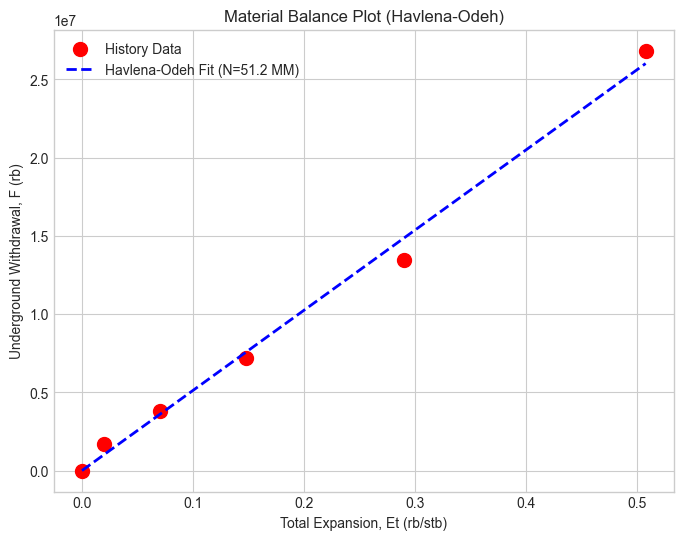

   Pressure           F     Et     Eo
0      3000         0.0  0.000  0.000
1      2800   1704000.0  0.020  0.020
2      2600   3825000.0  0.070  0.070
3      2400   7207800.0  0.148  0.148
4      2200  13481500.0  0.290  0.290
5      2000  26838600.0  0.508  0.508


In [3]:
# Initialize Solver
# m=0 (No gas cap), Pi=3000
solver = MaterialBalanceSolver(df_prod, df_pvt, Pi=3000, m=0)

# Calculate terms (Assuming compressibility is negligible for this simple case)
df_calc = solver.calculate_terms(cf=0, cw=0, Sw=0)

# Perform Linear Regression to find Slope (N)
# We force the intercept to be 0 (fit_intercept=False) because at P=Pi, F=0 and Et=0
X = df_calc['Et'].values.reshape(-1, 1)
y = df_calc['F'].values

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

N_calculated = model.coef_[0]

print(f"--- Calculated OOIP (N) ---")
print(f"Slope of the line: {N_calculated/1e6:.2f} MMSTB")

# --- PLOTTING ---
plt.figure(figsize=(8, 6))

# Scatter Plot of Data Points
plt.scatter(df_calc['Et'], df_calc['F'], color='red', s=100, label='History Data')

# Plot the Fitted Line
x_line = np.linspace(0, df_calc['Et'].max(), 100)
y_line = N_calculated * x_line
plt.plot(x_line, y_line, 'b--', linewidth=2, label=f'Havlena-Odeh Fit (N={N_calculated/1e6:.1f} MM)')

plt.xlabel('Total Expansion, Et (rb/stb)')
plt.ylabel('Underground Withdrawal, F (rb)')
plt.title('Material Balance Plot (Havlena-Odeh)')
plt.legend()
plt.grid(True)


plt.show()

# Show the data table
print(df_calc[['Pressure', 'F', 'Et', 'Eo']])

## 3. Diagnostic: What if there is Water Influx?

The beauty of the Havlena-Odeh method is that it acts as a diagnostic tool.

If we assumed $W_e = 0$ (Volumetric) but the reservoir **actually** had an aquifer, the points would **not** fall on a straight line. They would curve upward.

$$\frac{F}{E_t} = N + \frac{W_e}{E_t}$$

Let's simulate a "fake" water influx to see how the plot changes.

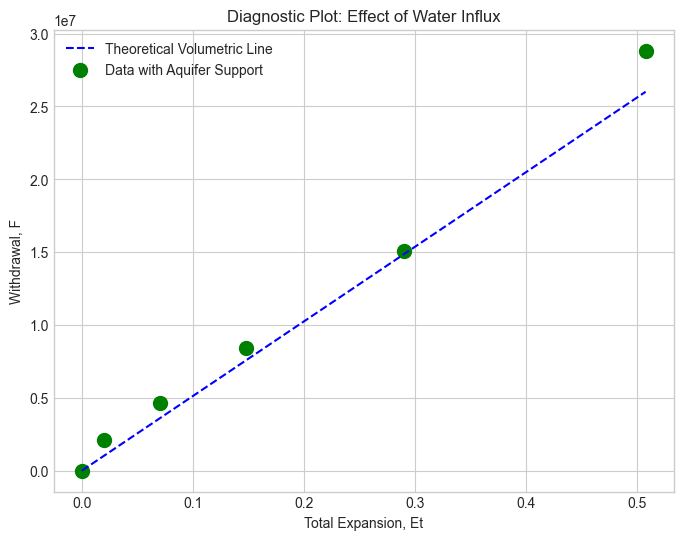

In [4]:
# Simulate an aquifer adding support (We increases with time/production)
# We add a fake We term to the Withdrawal F (F_apparent = F_real - We) 
# Wait, usually we plot F vs Et. If We exists, F = N*Et + We. 
# So F (y-axis) will be higher than expected for a given Et.

# Let's artificially boost F to simulate hidden water influx
df_calc['F_with_aquifer'] = df_calc['F'] + np.linspace(0, 2e6, len(df_calc))

plt.figure(figsize=(8, 6))

# Plot Original Volumetric Line
plt.plot(x_line, y_line, 'b--', label='Theoretical Volumetric Line')

# Plot Data with Water Influx
plt.scatter(df_calc['Et'], df_calc['F_with_aquifer'], color='green', s=100, label='Data with Aquifer Support')

plt.xlabel('Total Expansion, Et')
plt.ylabel('Withdrawal, F')
plt.title('Diagnostic Plot: Effect of Water Influx')
plt.legend()
plt.grid(True)
plt.show()

**Observation:**
The green points curve **upward** away from the straight line.
* This characteristic "hump" tells the engineer: *"Stop assuming it's a closed tank! You need to add a $W_e$ term (Chapter 10) to your equation."*

## Conclusion

1.  **The Class:** We built a reusable `MaterialBalanceSolver` class.
2.  **Linearization:** We transformed complex reservoir physics into a simple straight-line plot.
3.  **Slope = N:** We found the Initial Oil In Place without needing a complex simulator.
4.  **Diagnostics:** We visualized how water influx deviates from the trend.